In [1]:
%load_ext autoreload
%autoreload 2

!pip install -q -U git+https://github.com/sbrugman/SDGym.git@v0.2.2-hw

!pip install -q -U ../../

In [2]:
from timeit import default_timer as timer
from functools import partial
from random import choices
import logging

In [3]:
import sdgym
from sdgym import load_dataset
from sdgym import benchmark
from sdgym import load_dataset

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

In [5]:
import pgmpy

from pgmpy.models import BayesianModel
from pgmpy.estimators import TreeSearch, HillClimbSearch, BicScore, ExhaustiveSearch, BayesianEstimator
from pgmpy.sampling import BayesianModelSampling

In [6]:
import xgboost as xgb
from xgboost import XGBClassifier

In [7]:
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.isotonic import IsotonicRegression

In [8]:
from sklearn.metrics import (
    mutual_info_score,
    adjusted_mutual_info_score,
    normalized_mutual_info_score,
)

In [9]:
from scipy import interpolate

In [10]:
from phik.phik import phik_from_binned_array

In [11]:
from synthsonic.models.kde_utils import kde_smooth_peaks_1dim, kde_smooth_peaks
from synthsonic.models.kde_copula_nn_pdf import KDECopulaNNPdf

In [46]:
import matplotlib.pyplot as plt
plt.rcParams['text.color'] = 'black'
plt.rcParams['figure.max_open_warning'] = 0
colors = [i['color'] for i in plt.rcParams['axes.prop_cycle']]
markers = ['o', 's', 'p', 'x', '^', '+', '*', '<', 'D', 'h', '>']
%matplotlib inline

In [13]:
logging.basicConfig(level=logging.INFO)

In [14]:
dataset_name = 'adult'

In [15]:
data, categorical_columns, ordinal_columns = load_dataset(dataset_name)

INFO:sdgym.data:Loading dataset adult


In [16]:
data.shape

(22561, 15)

In [17]:
categorical_columns, ordinal_columns

([1, 5, 6, 7, 8, 9, 13, 14], [3])

In [18]:
for i in range(data.shape[1]):
    print (i, len(np.unique(data[:, i])))

0 72
1 9
2 16469
3 16
4 16
5 7
6 15
7 6
8 5
9 2
10 115
11 87
12 88
13 41
14 2


(array([17088.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,  5473.]),
 array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
        0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
        0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 ,
        0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875,
        0.9  , 0.925, 0.95 , 0.975, 1.   ], dtype=float32),
 <a list of 40 Patch objects>)

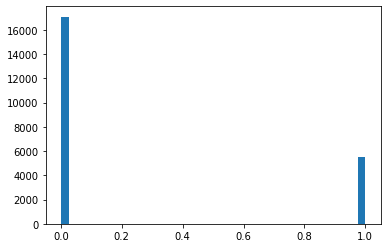

In [19]:
plt.hist(data[:, 14], bins=40)

In [20]:
data[:, 0]

array([27., 27., 25., ..., 45., 51., 61.], dtype=float32)

# run sdgym

In [22]:
all_features = list(range(data.shape[1]))
numerical_features = list(set(all_features) - set(categorical_columns + ordinal_columns))
data = np.float64(data)

n_samples = data.shape[0]
n_features = data.shape[1]

clf = xgb.XGBClassifier(
    n_estimators=250,
    reg_lambda=1,
    gamma=0,
    max_depth=9
)
#     clf = MLPClassifier(alpha=0.1, random_state=0, max_iter=1000, early_stopping=True)

kde = KDECopulaNNPdf(
    use_KDE=False, 
    numerical_columns=numerical_features,
    categorical_columns=categorical_columns+ordinal_columns,
    distinct_threshold=-1,
    n_uniform_bins=30,
    n_calibration_bins=100,
    test_size=0.25,
    edge_weights_fn=phik_from_binned_array # normalized_mutual_info_score
#        clf=clf,
#         ordering='mi',
)
kde = kde.fit(data)

#     X_gen, sample_weight = kde.sample(n_samples)
X_gen = kde.sample_no_weights(n_samples, show_progress=True)

INFO:KDECopulaNNPdf:Processing 6 numerical and 9 categorical columns
INFO:KDECopulaNNPdf:Transforming numerical variables.
INFO:KDECopulaNNPdf:Configuring Bayesian Network (cat+num).
INFO:KDECopulaNNPdf:n_uniform_bins = 30
Building tree: 100%|██████████| 91/91.0 [00:03<00:00, 27.88it/s]
INFO:KDECopulaNNPdf:Configuring classifier.
INFO:KDECopulaNNPdf:Generating 266920 data points.
Generating for node: 6: 100%|██████████| 15/15 [00:03<00:00,  4.57it/s] 
INFO:KDECopulaNNPdf:Fitting discriminative learner: selected 15 features.
INFO:KDECopulaNNPdf:Calibrating classifier.
INFO:KDECopulaNNPdf:N_bins = 100
INFO:KDECopulaNNPdf:Maximum weight found: 20.82072818930737
INFO:KDECopulaNNPdf:Generating 525675 data points.
Generating for node: 6: 100%|██████████| 15/15 [00:06<00:00,  2.22it/s] 


In [27]:
from sklearn.isotonic import IsotonicRegression

In [135]:
def _calibrate_classifier(hist_p0, hist_p1, bin_edges, use_sample_weights=True, validation_plots=False):
    """ Calibrate classifier based on probability histograms

    :param hist_p0:
    :param hist_p1:
    :param bin_edges:
    :return:
    """
    hist_p0 = hist_p0.astype(float)
    hist_p1 = hist_p1.astype(float)
    rest_p0 = np.sum(hist_p0) - hist_p0
    rest_p1 = np.sum(hist_p1) - hist_p1
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.
    bin_width = bin_edges[1] - bin_edges[0]

    def poisson_uncertainty(n):
        # return correct poisson counts (set to one for zero counts)
        sigma_n = np.sqrt(n)
        sigma_n[sigma_n == 0] = 1.
        return sigma_n

    sigma_bin0 = poisson_uncertainty(hist_p0)
    sigma_rest0 = poisson_uncertainty(rest_p0)
    sigma_bin1 = poisson_uncertainty(hist_p1)
    sigma_rest1 = poisson_uncertainty(rest_p1)

    def fraction_and_uncertainty(a, b, sigma_a, sigma_b):
        # return fraction a/(a+b) and uncertainty on it, given uncertainties on a and b
        sum_ab = a + b
        frac_a = np.divide(a, sum_ab, out=np.zeros_like(a), where=sum_ab != 0)
        frac_b = np.divide(b, sum_ab, out=np.zeros_like(b), where=sum_ab != 0)
        sigma_p1 = np.divide(frac_b * sigma_a, sum_ab, out=np.zeros_like(frac_b), where=sum_ab != 0)
        sigma_p2 = np.divide(frac_a * sigma_b, sum_ab, out=np.zeros_like(frac_a), where=sum_ab != 0)
        sigma_fa2 = np.power(sigma_p1, 2) + np.power(sigma_p2, 2)
        return frac_a, np.sqrt(sigma_fa2)

    frac0, sigma_frac0 = fraction_and_uncertainty(hist_p0, rest_p0, sigma_bin0, sigma_rest0)
    frac1, sigma_frac1 = fraction_and_uncertainty(hist_p1, rest_p1, sigma_bin1, sigma_rest1)
    p1cb, sigma_p1cb = fraction_and_uncertainty(frac1, frac0, sigma_frac1, sigma_frac0)

    # sample weight is set to zero in case both sigma_p1cb is zero
    sample_weight = np.divide(1., sigma_p1cb * sigma_p1cb, out=np.zeros_like(sigma_p1cb), where=sigma_p1cb != 0)
    sample_weight /= np.min(sample_weight[sample_weight > 0])
    sample_weight = sample_weight if use_sample_weights else None

    # make sure last entry is filled, from which max_weight is derived
    if p1cb[-1] == 0:
        filled = p1cb[(p1cb > 0) & (p1cb < 1)]
        if len(filled) > 0:
            p1cb[-1] = np.max(filled)
            if use_sample_weights:
                sample_weight[-1] = 1e-3

    # use isotonic regression to smooth out potential fluctuations in the p1 values
    # isotonic regression assumes that p1 can only be a rising function.
    # (we're assuming that if a classifier predicts a higher probability, the calibrated probability
    # will also be higher. This will generally be a safe assumption.)
    iso_reg = IsotonicRegression(y_min=0, y_max=1, increasing='auto').fit(bin_centers, p1cb, sample_weight)
    # iso_reg = IsotonicRegression(y_min=0, y_max=1).fit(bin_centers, p1cb)
    p1pred = iso_reg.predict(bin_centers)
    p1f_ = interpolate.interp1d(
        bin_edges[:-1],
        p1pred,
        kind='previous',
        bounds_error=False,
        fill_value="extrapolate"
    )
    max_p1f = np.max(p1pred)
    max_weight = max_p1f / (1. - max_p1f)
    return p1cb, sigma_p1cb, p1pred, p1f_, iso_reg, max_weight


In [ ]:
( qchisq(0.025, 2*x)/2, chi2chisq(0.975, 2*(x+1))/2 )

In [169]:
from scipy.stats import chi2

In [136]:
bin_edges = kde.bin_edges_
bin_width = bin_edges[1] - bin_edges[0]
bin_centers = kde.bin_centers_
hist_p0 = kde.hist_p0_
hist_p1 = kde.hist_p1_

In [137]:
p1cb, sigma_p1cb, p1pred, p1f_, iso_reg, max_weight = _calibrate_classifier(hist_p0, hist_p1, bin_edges, use_sample_weights=True)

In [138]:
max_weight

20.82072818930737

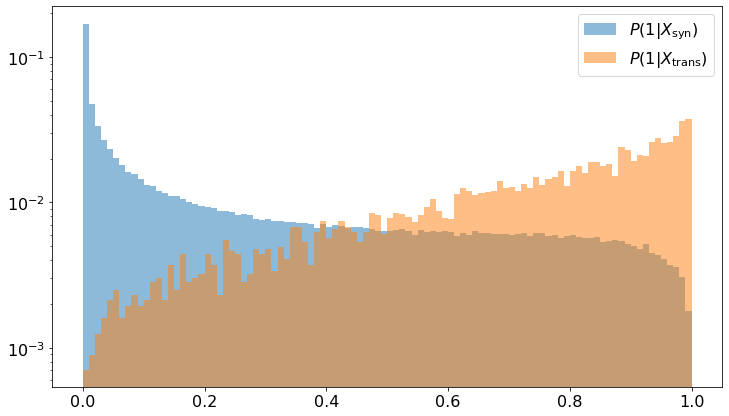

In [168]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.bar(bin_centers, hist_p0 / np.sum(hist_p0), width=bin_width, alpha=0.5, label=r'$P(1|X_{\rm syn})$', log=True, color=colors[0])
ax.bar(bin_centers, hist_p1 / np.sum(hist_p1), width=bin_width, alpha=0.5, label=r'$P(1|X_{\rm trans})$', log=True, color=colors[1])
ax.legend(fontsize=16)
ax.tick_params(labelsize=16)
fig.savefig(f'{dataset_name}_callibration_clf_hists.pdf', dpi=600)

In [89]:
sigma_p1cb_95 = sigma_p1cb * 1.96
sigma_lb = p1cb - sigma_p1cb_95
sigma_ub = p1cb + sigma_p1cb_95

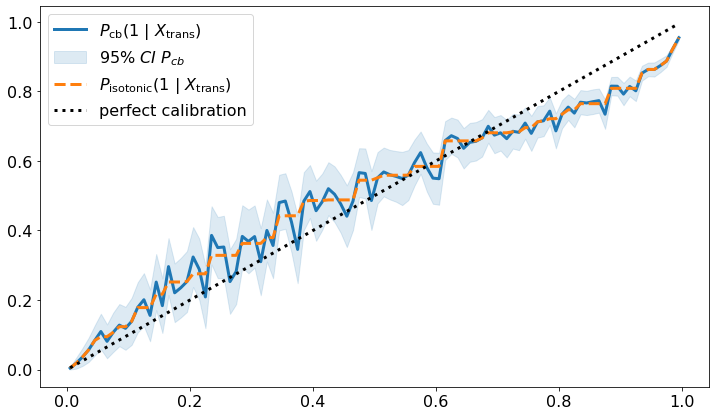

In [167]:
fig, ax = plt.subplots(figsize=(12, 7))
pcb = ax.plot(bin_centers, p1cb, label=r'$P_{\rm cb}(1~|~X_{\rm trans})$', lw=3, color=colors[0])
ci = ax.fill_between(bin_centers, sigma_lb, sigma_ub, label=r'$95\%~CI~P_{cb}$', color=colors[0], alpha=0.15)
piso = ax.plot(bin_centers, p1pred, label=r'$P_{\rm isotonic}(1~|~X_{\rm trans})$', lw=3, ls='--', color=colors[1])
pline = ax.plot(bin_centers, bin_centers, label='perfect calibration', lw=3, ls=':', color='black')

ax.tick_params(labelsize=16)
handles, labels = ax.get_legend_handles_labels()
handles_corr = [handles[0], handles[3], handles[1], handles[2]]
labels_corr = [labels[0], labels[3], labels[1], labels[2]]
ax.legend(handles_corr, labels_corr, fontsize=16)
fig.savefig(f'{dataset_name}_callibration_pcb_plot.pdf', dpi=600)

In [26]:
def KDECopulaNNPdf_Synthesizer(real_data, categorical_columns, ordinal_columns):
    all_features = list(range(real_data.shape[1]))
    numerical_features = list(set(all_features) - set(categorical_columns + ordinal_columns))
    data = np.float64(real_data)
    
    n_samples = data.shape[0]
    n_features = data.shape[1]
    
    clf = xgb.XGBClassifier(
        n_estimators=250,
        reg_lambda=1,
        gamma=0,
        max_depth=9
    )
#     clf = MLPClassifier(alpha=0.1, random_state=0, max_iter=1000, early_stopping=True)
    
    kde = KDECopulaNNPdf(
        use_KDE=False, 
        categorical_columns=categorical_columns+ordinal_columns,
        distinct_threshold=-1,
        n_uniform_bins=30,
        n_calibration_bins=100,
        test_size=0.25,
        edge_weights_fn=phik_from_binned_array # normalized_mutual_info_score
#        clf=clf,
#         ordering='mi',
    )
    kde = kde.fit(data)
    
#     X_gen, sample_weight = kde.sample(n_samples)
    X_gen = kde.sample_no_weights(n_samples, show_progress=True)
    
    X_gen[:, categorical_columns+ordinal_columns] = np.round(X_gen[:, categorical_columns+ordinal_columns])
    X_gen = np.float32(X_gen)
    
    print(X_gen[:, :5])

    return X_gen

In [27]:
def KDECopulaNNPdf_SynthesizerInteger(real_data, categorical_columns, ordinal_columns):
    """Census has integer only..."""
    data = KDECopulaNNPdf_Synthesizer(real_data, categorical_columns, ordinal_columns)
    data = np.round(data)
    
    print(data[:, :5])

    return data

In [28]:
from sdgym.synthesizers import (
    CLBNSynthesizer, CTGANSynthesizer, IdentitySynthesizer, IndependentSynthesizer,
    MedganSynthesizer, PrivBNSynthesizer, TableganSynthesizer, TVAESynthesizer,
    UniformSynthesizer, VEEGANSynthesizer)

all_synthesizers = [
    #IdentitySynthesizer,
    #IndependentSynthesizer,
    #KDECopulaNNPdf_Synthesizer,
    KDECopulaNNPdf_SynthesizerInteger,
]

In [29]:
scores = sdgym.run(synthesizers=all_synthesizers, datasets=[dataset_name], iterations=1)

INFO:sdgym.benchmark:0%|          | 0/1 [00:00<?, ?it/s]
INFO:sdgym.benchmark:Evaluating KDECopulaNNPdf_SynthesizerInteger on dataset adult; iteration 0; 334.19 MB
INFO:sdgym.data:Loading dataset adult (all variables)
INFO:sdgym.benchmark:Running KDECopulaNNPdf_SynthesizerInteger on dataset adult; iteration 0; 334.89 MB
INFO:KDECopulaNNPdf:Processing 6 numerical and 9 categorical columns
INFO:KDECopulaNNPdf:Transforming numerical variables.
INFO:KDECopulaNNPdf:Configuring Bayesian Network (cat+num).

  0%|          | 0/91.0 [00:00<?, ?it/s]
Building tree:   0%|          | 0/91.0 [00:00<?, ?it/s]
Building tree:  26%|██▋       | 24/91.0 [00:00<00:00, 68.10it/s]
Building tree:  34%|███▍      | 31/91.0 [00:00<00:00, 63.14it/s]
Building tree:  41%|████      | 37/91.0 [00:01<00:02, 25.14it/s]
Building tree:  45%|████▌     | 41/91.0 [00:01<00:01, 26.20it/s]
Building tree:  49%|████▉     | 45/91.0 [00:01<00:01, 24.70it/s]
Building tree:  53%|█████▎    | 48/91.0 [00:01<00:02, 18.18it/s]
Buildin

[[5.6000305e+01 5.0000000e+00 1.8038445e+05 1.2000000e+01 1.0000123e+01]
 [2.8001459e+01 0.0000000e+00 2.1270702e+05 8.0000000e+00 9.9997616e+00]
 [4.9784565e+01 0.0000000e+00 4.9295398e+04 8.0000000e+00 9.0000715e+00]
 ...
 [2.5999985e+01 0.0000000e+00 4.8528000e+05 6.0000000e+00 4.9999895e+00]
 [2.7001322e+01 4.0000000e+00 2.5854428e+05 1.1000000e+01 1.1999876e+01]
 [6.7999565e+01 0.0000000e+00 1.2839530e+05 8.0000000e+00 8.9999418e+00]]
[[5.60000e+01 5.00000e+00 1.80384e+05 1.20000e+01 1.00000e+01]
 [2.80000e+01 0.00000e+00 2.12707e+05 8.00000e+00 1.00000e+01]
 [5.00000e+01 0.00000e+00 4.92950e+04 8.00000e+00 9.00000e+00]
 ...
 [2.60000e+01 0.00000e+00 4.85280e+05 6.00000e+00 5.00000e+00]
 [2.70000e+01 4.00000e+00 2.58544e+05 1.10000e+01 1.20000e+01]
 [6.80000e+01 0.00000e+00 1.28395e+05 8.00000e+00 9.00000e+00]]


INFO:sdgym.evaluate:Evaluating using binary classifier AdaBoostClassifier
INFO:sdgym.evaluate:Evaluating using binary classifier LogisticRegression
INFO:sdgym.evaluate:Evaluating using binary classifier MLPClassifier
/Users/maxbaak/opt/miniconda3/envs/synthsonic/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
INFO:sdgym.benchmark:Finished KDECopulaNNPdf_SynthesizerInteger on dataset adult; iteration 0; 403.59 MB
INFO:sdgym.benchmark:100%|##########| 1/1 [00:42<00:00, 42.21s/it]


In [30]:
scores

,adult/accuracy,adult/f1,timestamp
VEEGANSynthesizer,0.718792,0.162142,2020-04-12 09:41:35.096775
CLBNSynthesizer,0.769225,0.305083,2020-10-17 09:46:54.494331
CTGAN,0.793808,0.608179,2020-10-17 09:46:54.494331
CTGANSynthesizer,0.797583,0.602407,2020-10-17 09:46:54.494331
CopulaGAN,0.785250,0.606638,2020-10-17 09:46:54.494331
GaussianCopulaCategorical,NaN,NaN,2020-10-17 09:46:54.494331
GaussianCopulaCategoricalFuzzy,0.765658,0.257748,2020-10-17 09:46:54.494331
GaussianCopulaOneHot,0.779675,0.198042,2020-10-17 09:46:54.494331
IdentitySynthesizer,0.824425,0.663006,2020-10-17 09:46:54.494331
IndependentSynthesizer,0.638117,0.151106,2020-10-17 09:46:54.494331
